## Setup

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import make_scorer
from sklearn.model_selection import TimeSeriesSplit, cross_validate # GroupKFold, GridSearchCV,
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from joblib import dump

from utils import (
    precision_at_k,
    recall_at_k,
)

/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:48: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html

## Data Loading

In [2]:
X_train_f = pd.read_csv("./output/X_train_f.csv") # 2010 - 2014, w. protected attributes
X_train_s = pd.read_csv("./output/X_train_s.csv") # 2010 - 2014, w/o protected attributes
y_train = pd.read_csv("./output/y_train.csv").iloc[:,0]

X_test_f = pd.read_csv("./output/X_test_f.csv")
X_test_s = pd.read_csv("./output/X_test_s.csv")
y_test = pd.read_csv("./output/y_test.csv").iloc[:,0]

## Correlation Analysis

In [3]:
# Computes the absolute value of the correlation matrix for the training features with protected attributes
corrM = X_train_f.corr().abs() # Corr matrix of X
corrM = corrM.unstack() # flatten
corrMo = corrM.sort_values(kind = "quicksort") # sort correlations
corrMo[corrMo < 1].tail(20) # Filters out the self-correlations (which equal 1) and prints the last 20 entries (lowest correlations)

# to spot which features (including protected‐attribute proxies) are most strongly correlated, so I can 
# watch out for multicollinearity or fairness-related leakage

ft_tot_dur_byage        ft_tot_dur                0.954161
ft_tot_dur              ft_tot_dur_byage          0.954161
maxbula.Missing.        lastjob_pt99999           0.954524
lastjob_pt99999         maxbula.Missing.          0.954524
seeking1_tot_dur_byage  seeking1_tot_dur          0.955420
seeking1_tot_dur        seeking1_tot_dur_byage    0.955420
lastjob_none            maxbula.Missing.          0.961120
maxbula.Missing.        lastjob_none              0.961120
lastjob_type99999       maxbula.Missing.          0.961120
maxbula.Missing.        tsince_lm_contact_cat5    0.961120
tsince_lm_contact_cat5  maxbula.Missing.          0.961120
maxbula.Missing.        lastjob_type99999         0.961120
                        lastjob_parallel99999     0.961120
lastjob_parallel99999   maxbula.Missing.          0.961120
emp1_total_dur          emp1_total_dur_byage      0.963495
emp1_total_dur_byage    emp1_total_dur            0.963495
secjob_tot_dur          secjob_tot_dur_byage      0.9658

In [4]:
tscv = TimeSeriesSplit(4) # Create splits by year

In [5]:
for train_index, test_index in tscv.split(X_train_f):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 4997 4998 4999] TEST: [5000 5001 5002 ... 9997 9998 9999]
TRAIN: [   0    1    2 ... 9997 9998 9999] TEST: [10000 10001 10002 ... 14997 14998 14999]
TRAIN: [    0     1     2 ... 14997 14998 14999] TEST: [15000 15001 15002 ... 19997 19998 19999]
TRAIN: [    0     1     2 ... 19997 19998 19999] TEST: [20000 20001 20002 ... 24997 24998 24999]


In [6]:
def precision_at_30(y_true, y_score, **kwargs):
    return precision_at_k(y_true, y_score, 0.30)
def precision_at_15(y_true, y_score, **kwargs):
    return precision_at_k(y_true, y_score, 0.15)
def recall_at_30(y_true, y_score, **kwargs):
    return recall_at_k(y_true, y_score, 0.30)
def recall_at_15(y_true, y_score, **kwargs):
    return recall_at_k(y_true, y_score, 0.15)

custom_precision30 = make_scorer(precision_at_30, needs_proba=True) # Precision at top 30%
custom_precision15 = make_scorer(precision_at_15, needs_proba=True) # Precision at top 15%
custom_recall30 = make_scorer(recall_at_30, needs_proba = True) # Recall at top 30%
custom_recall15 = make_scorer(recall_at_15, needs_proba = True) # Recall at top 15%

In [7]:
score = {'log_loss': 'neg_log_loss',
         'auc': 'roc_auc',
         'precision': 'precision', # uses default model threshold of 0.5
         'recall': 'recall',
         'precision_at_k30': custom_precision30, # uses custom threshold 
         'recall_at_k30': custom_recall30,
         'precision_at_k15': custom_precision15,
         'recall_at_k15': custom_recall15}

## 01 Logit Regression (w. protected attributes)

In [8]:
glm1 = LogisticRegression(penalty = None, solver = 'lbfgs', max_iter = 1000) #newton-cg
glm1.fit(X_train_f, y_train)

/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, penalty=None)

In [9]:
coefs1 = pd.DataFrame(X_train_f.columns, columns = ['var'])
coefs1['coef'] = pd.DataFrame(glm1.coef_).transpose()

# Build a DataFrame of feature names + their learned coefficients, to inspect which variables 
# (including protected attrs) the model weights most heavily.

In [10]:
dump(glm1, './models/glm1.joblib')

['./models/glm1.joblib']

### CV

In [11]:
glmcv1 = cross_validate(estimator = glm1, 
                       X = X_train_f,
                       y = y_train,
                       cv = tscv,
                       n_jobs = -1, # use all available cores
                       scoring = score)

/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  vect_normalized_discounted_cumulative_gain = vmap(
/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/inFairness/utils/ndcg.py:37: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.vmap` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.vmap` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html

                           mean       std
test_log_loss         -0.415914  0.008397
test_auc               0.701847  0.012086
test_precision         0.396163  0.015592
test_recall            0.151219  0.036058
test_precision_at_k30  0.160250  0.003181
test_recall_at_k30     1.000000  0.000000
test_precision_at_k15  0.160250  0.003181
test_recall_at_k15     1.000000  0.000000


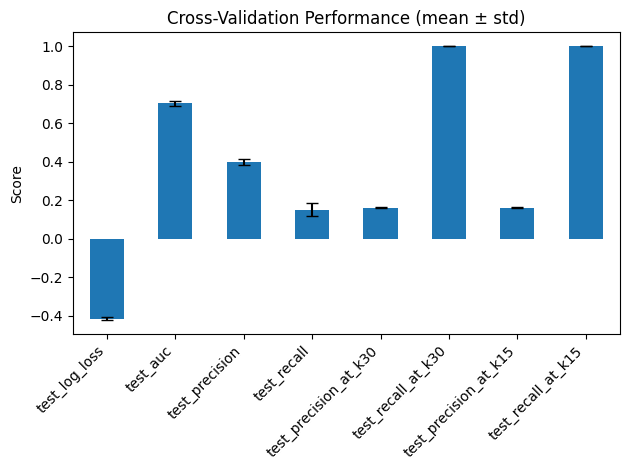

In [12]:
# Visualize CV output

# Convert to DataFrame
results_df = pd.DataFrame(glmcv1)

# Only keep test scores
test_scores = results_df.filter(like='test_')

# Summary statistics
summary = test_scores.agg(['mean', 'std']).T
summary.columns = ['mean', 'std']
print(summary)

import matplotlib.pyplot as plt

# Bar chart of mean ± std
summary.plot(kind='bar', y='mean', yerr='std', legend=False, capsize=4)
plt.ylabel("Score")
plt.title("Cross-Validation Performance (mean ± std)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

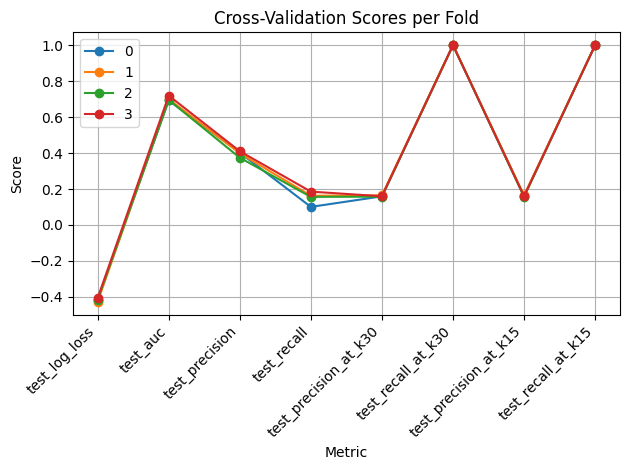

In [13]:
# Visualize CV output

test_scores.T.plot(marker='o')
plt.title("Cross-Validation Scores per Fold")
plt.xlabel("Metric")
plt.ylabel("Score")
plt.grid(True)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 02 Logit Regression (w/o protected attributes)

In [14]:
glm2 = LogisticRegression(penalty = None, solver = 'lbfgs', max_iter = 1000) #'newton-cg'
glm2.fit(X_train_s, y_train)

/Users/julia/Desktop/CMA_Fairness/cma_f/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, penalty=None)

In [15]:
coefs2 = pd.DataFrame(X_train_s.columns, columns = ['var'])
coefs2['coef'] = pd.DataFrame(glm2.coef_).transpose()

In [16]:
dump(glm2, './models/glm2.joblib')

['./models/glm2.joblib']

## Predict

In [17]:
k45 = 0.55 # Top 55% 
k30 = 0.30 # Top 30% 
k15 = 0.15 # Top 15%

In [18]:
glm1_p = glm1.predict_proba(X_test_f)[:,1] # glm1

# Generate the predicted probability of the positive class for each test sample

In [19]:
threshold45 = np.sort(glm1_p)[::-1][int(k45*len(glm1_p))]
threshold30 = np.sort(glm1_p)[::-1][int(k30*len(glm1_p))]
threshold15 = np.sort(glm1_p)[::-1][int(k15*len(glm1_p))] # threshold15 is the score above which only the top 15% of test samples lie

In [20]:
glm1_c1 = glm1_p.copy()
glm1_c1[glm1_c1 < threshold15] = 0
glm1_c1[glm1_c1 >= threshold15] = 1

# Create a binary classification vector where only the top 15% by predicted probability are labeled “1”

In [21]:
glm1_c2 = glm1_p.copy()
glm1_c2[glm1_c2 < threshold30] = 0
glm1_c2[glm1_c2 >= threshold30] = 1

In [22]:
glm1_c3 = glm1_p.copy()
glm1_c3[(glm1_c3 <= threshold30) | (glm1_c3 >= threshold15)] = 0
glm1_c3[(glm1_c3 > threshold30) & (glm1_c3 < threshold15)] = 1

In [23]:
glm1_c4 = glm1_p.copy()
glm1_c4[(glm1_c4 <= threshold45) | (glm1_c4 >= threshold15)] = 0
glm1_c4[(glm1_c4 > threshold45) & (glm1_c4 < threshold15)] = 1

In [24]:
glm2_p = glm2.predict_proba(X_test_s)[:,1] # glm2

In [25]:
threshold45 = np.sort(glm2_p)[::-1][int(k45*len(glm2_p))]
threshold30 = np.sort(glm2_p)[::-1][int(k30*len(glm2_p))]
threshold15 = np.sort(glm2_p)[::-1][int(k15*len(glm2_p))]

In [26]:
glm2_c1 = glm2_p.copy()
glm2_c1[glm2_c1 < threshold15] = 0
glm2_c1[glm2_c1 >= threshold15] = 1

In [27]:
glm2_c2 = glm2_p.copy()
glm2_c2[glm2_c2 < threshold30] = 0
glm2_c2[glm2_c2 >= threshold30] = 1

In [28]:
glm2_c3 = glm2_p.copy()
glm2_c3[(glm2_c3 <= threshold30) | (glm2_c3 >= threshold15)] = 0
glm2_c3[(glm2_c3 > threshold30) & (glm2_c3 < threshold15)] = 1

In [ ]:
# glm2_c4 ...

## Performance evaluation -> delete?

In [32]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, balanced_accuracy_score


In [33]:
for preds, label in zip(
    [glm1_c1, glm1_c2, glm1_c3, glm1_c4],
    ["Top 15%", "Top 30%", "Middle 15-30%", "Middle 15-45%"]
):
    acc = accuracy_score(y_test, preds)
    f1  = f1_score(y_test, preds)
    bal_acc = balanced_accuracy_score(y_test, preds)
    print(f"{label:15s} → Accuracy: {acc:.3f},  F1-score: {f1:.3f},  Balanced Acc: {bal_acc:.3f}")

Top 15%         → Accuracy: 0.814,  F1-score: 0.333,  Balanced Acc: 0.621
Top 30%         → Accuracy: 0.709,  F1-score: 0.321,  Balanced Acc: 0.635
Middle 15-30%   → Accuracy: 0.767,  F1-score: 0.162,  Balanced Acc: 0.515
Middle 15-45%   → Accuracy: 0.579,  F1-score: 0.204,  Balanced Acc: 0.511


## Combine and save

In [36]:
'''
Build a single DataFrame side by side with:
      - The true labels (‘y_test’)
      - The raw predicted probabilities (‘glm1_p’)
      - Each binary decision vector at different cutoffs (‘glm1_c1’, ‘glm1_c2’, ‘glm1_c3’).
'''

preds_test = pd.concat([pd.DataFrame(np.array(y_test), columns = ['y_test']),
                         pd.DataFrame(glm1_p, columns = ['glm1_p']),
                         pd.DataFrame(glm1_c1, columns = ['glm1_c1']),
                         pd.DataFrame(glm1_c2, columns = ['glm1_c2']),
                         pd.DataFrame(glm1_c3, columns = ['glm1_c3']),
                         pd.DataFrame(glm1_c4, columns = ['glm1_c4']),
                         pd.DataFrame(glm2_p, columns = ['glm2_p']),
                         pd.DataFrame(glm2_c1, columns = ['glm2_c1']),
                         pd.DataFrame(glm2_c2, columns = ['glm2_c2']),
                         pd.DataFrame(glm2_c3, columns = ['glm2_c3'])],
                        axis = 1)

In [37]:
preds_test.to_csv('./output/preds_test.csv', index = False)

## Confusion Matrix

In [27]:
# glm1 

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Define your predictions
threshold_preds = {
    "Top 15% (glm1_c1)": glm1_c1,
    "Top 30% (glm1_c2)": glm1_c2,
    "Between 15% and 30% (glm1_c3)": glm1_c3,
    "Between 15% and 45% (glm1_c4)": glm1_c4,
}

# Evaluate
results = []

for label, y_pred in threshold_preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )

    results.append({
        "Policy": label,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

# Display as DataFrame
df_threshold_metrics = pd.DataFrame(results)
print(df_threshold_metrics)


                          Policy    TP     FP     TN    FN  Precision  \
0              Top 15% (glm1_c1)  4292   9165  69037  7216   0.318942   
1              Top 30% (glm1_c2)  7188  19726  58476  4320   0.267073   
2  Between 15% and 30% (glm1_c3)  2896  10560  67642  8612   0.215220   
3  Between 15% and 45% (glm1_c4)  5576  30307  47895  5932   0.155394   

     Recall        F1  
0  0.372958  0.343841  
1  0.624609  0.374161  
2  0.251651  0.232014  
3  0.484532  0.235319  


In [38]:
# glm2 

# Define your predictions
threshold_preds = {
    "Top 15% (glm2_c1)": glm2_c1,
    "Top 30% (glm2_c2)": glm2_c2,
    "Between 15% and 30% (glm1_c3)": glm2_c3,
}

# Evaluate
results = []

for label, y_pred in threshold_preds.items():
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred, average="binary", zero_division=0
    )

    results.append({
        "Policy": label,
        "TP": tp,
        "FP": fp,
        "TN": tn,
        "FN": fn,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

# Display as DataFrame
df_threshold_metrics = pd.DataFrame(results)
print(df_threshold_metrics)


                          Policy    TP     FP     TN    FN  Precision  \
0              Top 15% (glm2_c1)  4311   9146  69056  7197   0.320354   
1              Top 30% (glm2_c2)  7222  19692  58510  4286   0.268336   
2  Between 15% and 30% (glm1_c3)  2910  10546  67656  8598   0.216260   

     Recall        F1  
0  0.374609  0.345364  
1  0.627563  0.375930  
2  0.252868  0.233136  
